In [55]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from scipy import optimize
import re
import copy
import logging
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
sns.set()

# a little hacky, but works if you don't want to actually install the
# custom packages 
sys.path.append('../')
from uniswapv3_simulator.pool import Uniswapv3Pool
from uniswapv3_simulator.utils import *
from uniswapv3_simulator.math import tick_to_sqrt_price, sqrt_price_to_tick
from utils import amount_to_float

from config import ALPHAVANTAGE_API_KEY

In [56]:
POOL = 'USDC-WETH-500'
MAX_DATE = '2022-01-28'
SAVED_POOLS = f'./saved-pools/{POOL}.pickle'
SAVED_RETURNS = f'./saved-returns/{POOL}.pickle'

timestamp = datetime.now().strftime('%y%m%d%H%M%S')
logging.basicConfig(level=logging.INFO,
                    filename=f'./logs/{POOL}_{timestamp}.log')
logging.getLogger('uniswap-v3').setLevel(logging.INFO)
logging.getLogger('uniswap-v3.utils').setLevel(logging.DEBUG)

In [57]:
data = pd.read_pickle('../data/pool_data_clean.pickle')
swaps = data[POOL]['swaps']
liquidity = data[POOL]['liquidity']

In [58]:
swaps.info()
swaps.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247617 entries, 0 to 1247616
Data columns (total 18 columns):
 #   Column                          Non-Null Count    Dtype              
---  ------                          --------------    -----              
 0   swap_time                       1247617 non-null  datetime64[ns, UTC]
 1   tx_hash                         1247617 non-null  string             
 2   token_0_amount                  1247617 non-null  float64            
 3   token_1_amount                  1247617 non-null  float64            
 4   pool_address                    1247617 non-null  string             
 5   price_tick                      1247617 non-null  int64              
 6   price_tick_adjusted             1247617 non-null  float64            
 7   contract_address_token_0        1247617 non-null  string             
 8   contract_name_token_0           1247617 non-null  string             
 9   contract_ticker_symbol_token_0  1247617 non-null  string 

,swap_time,tx_hash,token_0_amount,token_1_amount,pool_address,price_tick,price_tick_adjusted,contract_address_token_0,contract_name_token_0,contract_ticker_symbol_token_0,contract_decimals_token_0,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,pool_fee,pool_tick_spacing,pool_deploy_time
0,2022-01-30 04:52:19+00:00,0x36621c4daf5223d66e6b95b71e980e2135201db0c154...,-129.038949,0.050000,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,197756,0.000387,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,500,10,2021-05-05 21:42:11+00:00
1,2022-01-30 04:52:19+00:00,0xf78b59b49af825cb4a8bddc5de096fdacc057e67ef89...,-25807.129150,10.000000,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,197757,0.000387,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,500,10,2021-05-05 21:42:11+00:00
2,2022-01-30 04:48:53+00:00,0x432fd168796a6a60378e5b2dd517669f3561d30c785e...,-19691.729042,7.630000,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,197756,0.000387,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,500,10,2021-05-05 21:42:11+00:00
3,2022-01-30 04:47:53+00:00,0xee6a0812c1fef124feab8a3d16eb8746a42296de4e43...,297650.337110,-115.247573,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,197756,0.000387,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,500,10,2021-05-05 21:42:11+00:00
4,2022-01-30 04:47:30+00:00,0xc1d9409536ab979f2f3c398a08b233320c742b1409c2...,-27219.066547,10.552313,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,197762,0.000387,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,500,10,2021-05-05 21:42:11+00:00


In [59]:
liquidity.info()
liquidity.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31210 entries, 0 to 31209
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   txn_time                        31210 non-null  datetime64[ns, UTC]
 1   tx_hash                         31210 non-null  string             
 2   token_0_amount                  31210 non-null  float64            
 3   token_1_amount                  31210 non-null  float64            
 4   pool_address                    31210 non-null  string             
 5   liquidity_event                 31210 non-null  string             
 6   price_tick_lower                31210 non-null  int64              
 7   price_tick_upper                31210 non-null  int64              
 8   price_tick_lower_adjusted       31210 non-null  float64            
 9   price_tick_upper_adjusted       31210 non-null  float64            
 10  contract_a

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_decimals_token_0,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2022-01-29 18:52:48+00:00,0xaac213e229e4587d4981d05bbab06da2f7c64c70139e...,1212.627978,2.090520,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,ADD_LIQUIDITY,196910,197880,0.000356,0.000392,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,IncreaseLiquidity,500,10,2021-05-05 21:42:11+00:00,0.002733
1,2022-01-29 18:52:46+00:00,0x27993e06ca64d24bfbfa67993ac425b48b3d647085c4...,45631.897804,78.669352,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,ADD_LIQUIDITY,196910,197880,0.000356,0.000392,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,IncreaseLiquidity,500,10,2021-05-05 21:42:11+00:00,0.102843
2,2022-01-29 18:52:09+00:00,0xd2e45378cb7051760d5684343abec778e761044b26ed...,256006.205333,0.000000,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,REMOVE_LIQUIDITY,197730,198660,0.000386,0.000424,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,500,10,2021-05-05 21:42:11+00:00,-0.110743
3,2022-01-29 18:48:47+00:00,0xd274375a0422f6c1dac70bd7d9a225b458fe0f1f6d97...,169559.787040,90.000000,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,ADD_LIQUIDITY,197380,197970,0.000373,0.000396,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,IncreaseLiquidity,500,10,2021-05-05 21:42:11+00:00,0.270260
4,2022-01-29 18:39:34+00:00,0xafb3ad5c97e4d0300c62e5877530666809b322d53134...,1216.740422,0.399859,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,ADD_LIQUIDITY,193380,203190,0.000250,0.000667,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,IncreaseLiquidity,500,10,2021-05-05 21:42:11+00:00,0.000102


In [60]:
adds = liquidity.loc[liquidity['liquidity_event'] == 'ADD_LIQUIDITY', :].copy()
adds = adds.sort_values('txn_time').reset_index(drop=True)
adds.head()

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_decimals_token_0,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2021-05-05 21:42:11+00:00,0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...,2995.507735,1.000000,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,ADD_LIQUIDITY,191150,198080,0.000200,0.000400,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,500,10,2021-05-05 21:42:11+00:00,0.000345
1,2021-05-05 22:44:11+00:00,0xa564ea4677bda271bbb2eebec9774577b9b101c46eaf...,1.000000,0.000146,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,ADD_LIQUIDITY,194990,195010,0.000294,0.000294,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,500,10,2021-05-05 21:42:11+00:00,0.000026
2,2021-05-05 23:34:39+00:00,0xef93747acabe06ab11f663321f0de466bf9ae35888ba...,598.469729,2.600000,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,ADD_LIQUIDITY,186730,195460,0.000129,0.000308,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,500,10,2021-05-05 21:42:11+00:00,0.000448
3,2021-05-05 23:44:49+00:00,0x5f066eb8fefba0d1b491ffb924b708dc24158192a77f...,3405.610348,0.000000,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,ADD_LIQUIDITY,194660,194990,0.000284,0.000294,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,IncreaseLiquidity,500,10,2021-05-05 21:42:11+00:00,0.003508
4,2021-05-05 23:48:19+00:00,0x5184d8d442ac1696e9f7fb89c31db8c1de8ae9c80f3e...,1549.658850,0.151653,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,ADD_LIQUIDITY,194640,194660,0.000284,0.000284,...,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,IncreaseLiquidity,500,10,2021-05-05 21:42:11+00:00,0.035119


In [61]:
first_add_hash = adds.at[0, 'tx_hash']
print(f'First liquidity add hash: {first_add_hash}')

First liquidity add hash: 0x125e0b641d4a4b08806bf52c0c6757648c9963bcda8681e4f996f09e00d4c2cc


In [62]:
# from https://etherscan.io/tx/0x125e0b641d4a4b08806bf52c0c6757648c9963bcda8681e4f996f09e00d4c2cc#eventlog
liquidity_delta = amount_to_float('345073104699360', 18)  # belive all liquidity amounts use 18 decimals
assert liquidity_delta == adds.at[0, 'liquidity']

token0 = adds.at[0, 'token_0_amount']
token1 = adds.at[0, 'token_1_amount']
tick_lower = adds.at[0, 'price_tick_lower']
tick_upper = adds.at[0, 'price_tick_upper']
token0_decimals = adds.at[0, 'contract_decimals_token_0']
token1_decimals = adds.at[0, 'contract_decimals_token_1']

init_price = pool_init_price(token0, token1, tick_upper, tick_lower, liquidity_delta,
                             token0_decimals, token1_decimals)

token0_symb = liquidity.at[0, 'contract_ticker_symbol_token_0']
token1_symb = liquidity.at[0, 'contract_ticker_symbol_token_1']
print(f'Pool initial price ({token1_symb}/{token0_symb}): {init_price:,.12e}')
print(f'Pool initial price ({token0_symb}/{token1_symb}): {1 / init_price:,.12e}')

Pool initial price (WETH/USDC): 2.904162146572e+08
Pool initial price (USDC/WETH): 3.443333910196e-09


In [63]:
sqrt_price_x96 = 1.350174849792634181862360983626536e+33
etherscan_price = sqrt_price_x96 ** 2 / 2 ** 192
print(f"Calculated initial price: {init_price:.12e}")
print(f"Price per Etherscan:      {etherscan_price:.12e}")

Calculated initial price: 2.904162146572e+08
Price per Etherscan:      2.904162146577e+08


In [64]:
all_txn = organize_txns(liquidity, swaps, max_date=MAX_DATE)
all_txn

,orig_idx,tx_hash,txn_time,event
0,31209,0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...,2021-05-05 21:42:11+00:00,ADD_LIQUIDITY
1,1247616,0x0804ff007263a885191f23c808a9346e62d502a1fc23...,2021-05-05 22:15:01+00:00,SWAP
2,31207,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,2021-05-05 22:27:41+00:00,REMOVE_LIQUIDITY
3,31208,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,2021-05-05 22:27:41+00:00,REMOVE_LIQUIDITY
4,31206,0xa564ea4677bda271bbb2eebec9774577b9b101c46eaf...,2021-05-05 22:44:11+00:00,ADD_LIQUIDITY
...,...,...,...,...
1268554,10185,0x59a47e08919bc1b56aa94f75cd38ab6922bdb20f70ca...,2022-01-27 23:59:47+00:00,SWAP
1268555,10186,0xb2f99e85a17466bd82b9d035f7026dbd5b30616f7b7d...,2022-01-27 23:59:47+00:00,SWAP
1268556,10187,0xc5a7f435798215884699b38c501029eb51d0523b571a...,2022-01-27 23:59:47+00:00,SWAP
1268557,10188,0xf8a3be1cbc7ae3a8b31d5815847a1f32e72eef796511...,2022-01-27 23:59:47+00:00,SWAP


In [11]:
CHECKS_ON = False
# need to think about appropriate error tolerances
# TODO: maybe base these tolerances on the average transaction size?
TOKEN0_TOLS = {'atol': 1e-12, 'rtol': 1e-8}
TOKEN1_TOLS = {'atol': 1e-12, 'rtol': 1e-8}
LIQUIDITY_TOLS = {'atol': 1e-8, 'rtol': 1e-5}

In [ ]:
# there are >1.2M transactions, so we don't show the logging here
pool_snapshots, tx_results = run_historical_pool(
    init_price, 
    all_txn, 
    liquidity, 
    swaps,
    position_id='generic_LP', 
    checks_on=CHECKS_ON, 
    verbose=True,
    token0_tols=TOKEN0_TOLS,
    token1_tols=TOKEN1_TOLS,
    liquidity_tols=LIQUIDITY_TOLS
)
pd.to_pickle(pool_snapshots, SAVED_POOLS)

In [89]:
pool_snapshots = pd.read_pickle(SAVED_POOLS)

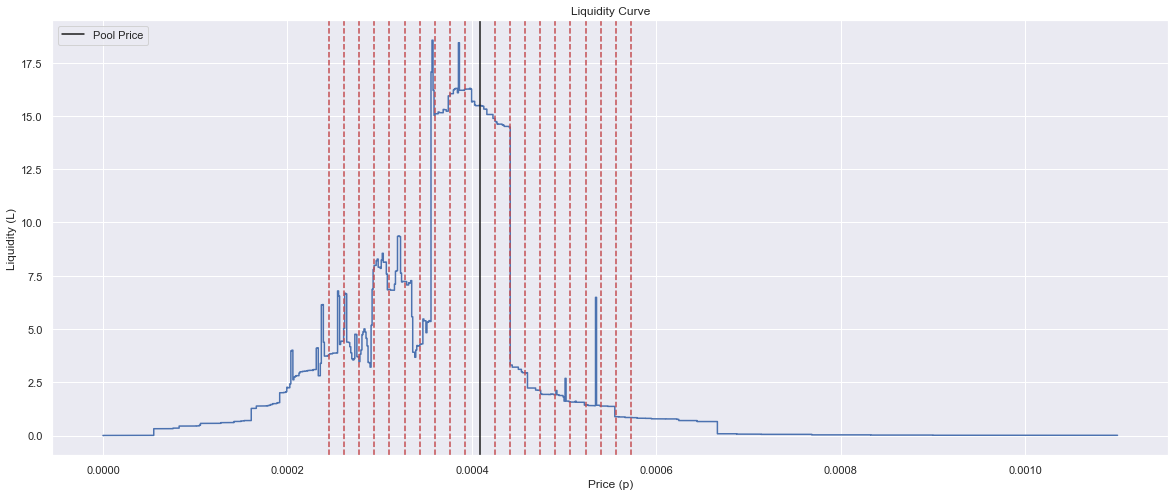

In [95]:
example_day = '2022-01-27'
sigma = 0.04
pool = pool_snapshots[example_day]
price_bins = np.array(
    [0]
    + [pool.price * (1 + i * sigma) for i in range(-10, 11)]
    + [np.inf]
)

fig, ax = plt.subplots(figsize=(20, 8))
pool.plot_liquidity_curve(interval=(0, 0.001), ax=ax)

for price in price_bins[1:-1]:
    if price == pool.price:
        ax.axvline(price, color='k', label='Pool Price')
    else:
        ax.axvline(price, color='r', linestyle='--')
ax.legend(loc='upper left')

plt.show()

In [96]:
%%time
numeraire_token = 0
sigma = 0.04
all_returns = {}

for day, start_pool in pool_snapshots.items():
    price_bins = np.array(
        [0]
        + [start_pool.price * (1 + i * sigma) for i in range(-10, 11)]
        + [np.inf]
    )
    day_txn = all_txn.loc[all_txn['txn_time'].dt.date == pd.to_datetime(day)]
    irrs = calc_irr_per_bin(start_pool, price_bins, day_txn, liquidity, swaps,
                            numeraire_token=numeraire_token, position_id='generic_LP')
    all_returns[day] = irrs
    
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)

CPU times: user 14min 58s, sys: 20.9 s, total: 15min 19s
Wall time: 15min 25s


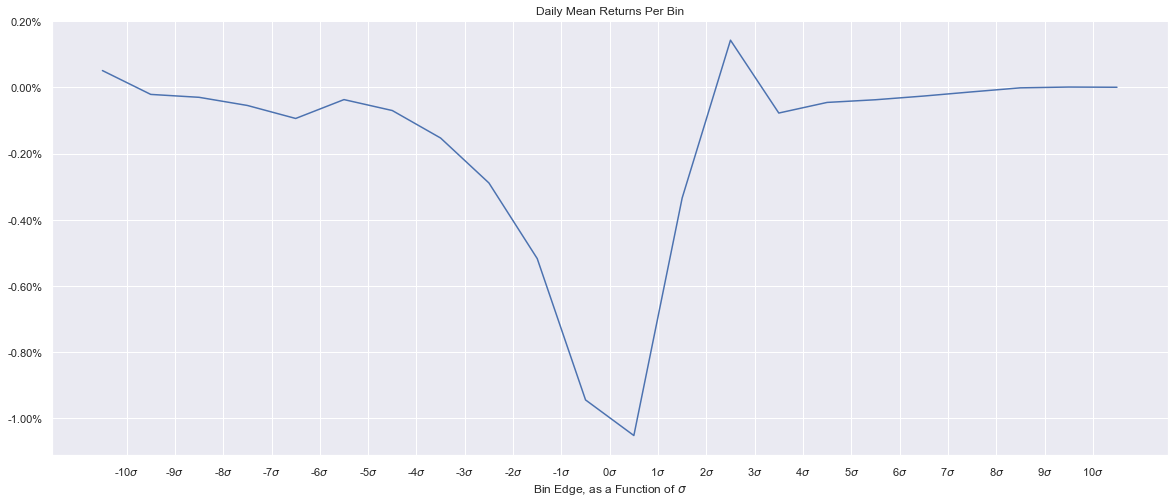

In [97]:
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Daily Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

In [16]:
pd.to_pickle(all_returns, SAVED_RETURNS)

In [27]:
import requests
from arch import arch_model
import statsmodels.api as sm

def get_daily_prices(token, api_key):
    url = (
        f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&'
        f'symbol={token}&market=USD&apikey={ALPHAVANTAGE_API_KEY}'
    )
    response = requests.get(url)
    data = response.json()
    
    df = pd.DataFrame(data['Time Series (Digital Currency Daily)']).T
    df = df.loc[:, ['4a. close (USD)']].copy()
    df.index = pd.to_datetime(df.index)
    df = df.resample('D').first()
    df.rename(columns={'4a. close (USD)': 'close'}, inplace=True)
    df['close'] = pd.to_numeric(df['close'])
    
    return df

In [4]:
eth_prices = get_daily_prices('ETH', ALPHAVANTAGE_API_KEY)
eth_ret = np.log(eth_prices).diff(1).dropna()

In [54]:
garch = arch_model(eth_ret * 100, p=1, o=0, q=1, dist='normal')
res = garch.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4768.93205394755
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3110.2082609979325
Iteration:      3,   Func. Count:     20,   Neg. LLF: 3342.7154296083777
Iteration:      4,   Func. Count:     27,   Neg. LLF: 3023.746053498555
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3068.9938830279275
Iteration:      6,   Func. Count:     39,   Neg. LLF: 3020.241685235883
Iteration:      7,   Func. Count:     45,   Neg. LLF: 3016.9006275714655
Iteration:      8,   Func. Count:     51,   Neg. LLF: 3016.8134186079005
Iteration:      9,   Func. Count:     56,   Neg. LLF: 3016.8132797454136
Iteration:     10,   Func. Count:     61,   Neg. LLF: 3016.8132719912546
Iteration:     11,   Func. Count:     65,   Neg. LLF: 3016.813271991183
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3016.8132719912546
            Iterations: 11
            Function evaluations: 65
            Gradient evaluati

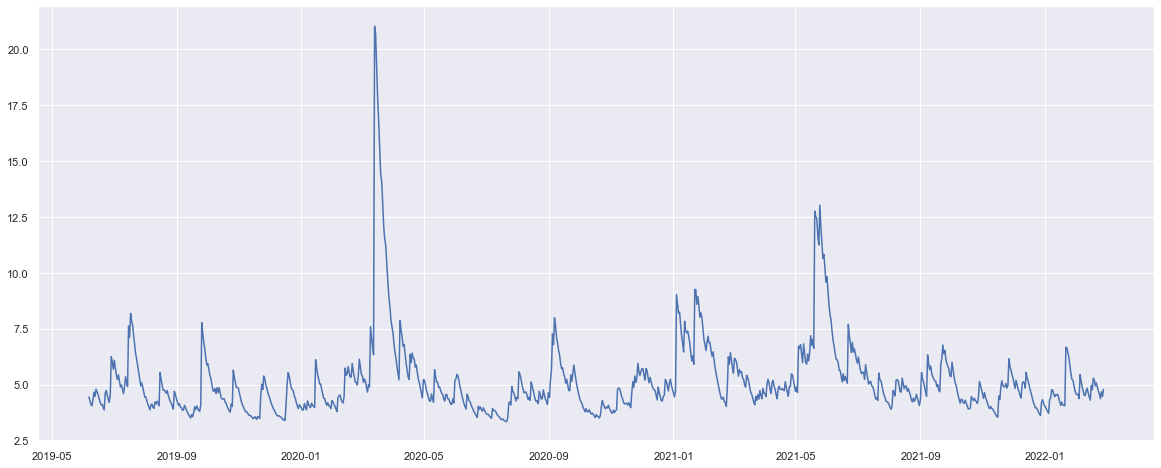

In [42]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(res.conditional_volatility)
plt.show()

In [43]:
all_returns = pd.read_pickle(SAVED_RETURNS)

In [44]:
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append((irr, day))

In [80]:
swaps['swap_day'] = swaps['swap_time'].dt.date
swaps_per_day = swaps.groupby('swap_day')['tx_hash'].count()
swaps_per_day.index = pd.to_datetime(swaps_per_day.index)
swaps_per_day.name = 'n_swaps'

swaps['swap_size'] = abs(swaps['token_0_amount'])
swaps_size = swaps.groupby('swap_day')['swap_size'].mean()
swaps_size.index = pd.to_datetime(swaps_size.index)
swaps_size.name = 'swap_size'

In [82]:
for i in range(1, 23):    
    ret = pd.Series(*zip(*bin_returns[i]))
    ret.index = pd.to_datetime(ret.index)
    ret.name = 'return'
    
    data = ret.to_frame().merge(res.conditional_volatility / 100, how='left', 
                                left_index=True, right_index=True)
    data = data.merge(swaps_per_day, how='left', 
                      left_index=True, right_index=True)
    data = data.merge(swaps_size, how='left', 
                      left_index=True, right_index=True)
    
    # data['cond_vol'] = (data['cond_vol'] - data['cond_vol'].mean()) / data['cond_vol'].std()
    data['n_swaps'] = (data['n_swaps'] - data['n_swaps'].mean()) / data['n_swaps'].std()
    data['swap_size'] = (data['swap_size'] - data['swap_size'].mean()) / data['swap_size'].std()
    x = sm.add_constant(data.loc[:, ['cond_vol', 'n_swaps', 'swap_size']])
    y = data['return']
    
    model = sm.OLS(y, x)
    ols_res = model.fit(cov_type='HC1')
    print(f' Bin {i - 11} '.center(78, '='))
    print(ols_res.summary())
    print('')

================================== Bin -10 ===================================
                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3470
Date:                Mon, 28 Feb 2022   Prob (F-statistic):              0.791
Time:                        10:40:06   Log-Likelihood:                 397.90
No. Observations:                 267   AIC:                            -787.8
Df Residuals:                     263   BIC:                            -773.5
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3802
Date:                Mon, 28 Feb 2022   Prob (F-statistic):              0.767
Time:                        10:40:06   Log-Likelihood:                 402.68
No. Observations:                 267   AIC:                            -797.4
Df Residuals:                     263   BIC:                            -783.0
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0100      0.017      0.582      0.5

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7128
Date:                Mon, 28 Feb 2022   Prob (F-statistic):              0.545
Time:                        10:40:06   Log-Likelihood:                 663.38
No. Observations:                 267   AIC:                            -1319.
Df Residuals:                     263   BIC:                            -1304.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.006      0.511      0.6

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                    0.5176
Date:                Mon, 28 Feb 2022   Prob (F-statistic):              0.671
Time:                        10:40:06   Log-Likelihood:                 1778.2
No. Observations:                 267   AIC:                            -3548.
Df Residuals:                     263   BIC:                            -3534.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -9.94e-05   8.81e-05     -1.128      0.2